**Imports** 🕵️‍♂️

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from scipy.signal import detrend
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

**Functions** 🤌

In [103]:
def check_data_balance(y):
    counter = Counter(y)
    for label, count in counter.items():
        percentage = (count / len(y)) * 100
        print(f"Class {label}: {count} samples ({percentage:.2f}%)")

# Preprocessing function for train and test sets
def preprocess(df, target):
    # Copy the dataframe
    df = df.copy()
    
    # Fill NaNs in specific columns with 0
    df['PSARl_0.01_0.1'] = df['PSARl_0.01_0.1'].fillna(0)
    df['PSARs_0.01_0.1'] = df['PSARs_0.01_0.1'].fillna(0)

    # Identify the first non-null row
    first_valid_index = df.dropna().index[0]

    # Drop the rows before this index in both features and target data
    df = df.loc[first_valid_index:]
    target = target.loc[first_valid_index:]

    # Use ffill to fill any remaining missing values
    df.ffill(inplace=True)

    # Return the processed dataframe and target
    return df, target



**Globals** 🌎

In [104]:
# # Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

feature_names = [
    # Fundamental price data
    'open', 'high', 'low', 'close', 

    # Auxiliary data
    'turnover', 'color',

    # Volume-related
    'volume', 'avg_vol_last_100', 'obv', 

    # Momentum and trend indicators
    'RSI_5', 'RSI_10', 'RSI_14',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'MACD_6_13_5_6_13_5', 'MACDh_6_13_5_6_13_5', 'MACDs_6_13_5_6_13_5', 

    # Moving averages
    'SMA_20', 'SMA_5', 'SMA_10', 'EMA_2', 'EMA_5', 'EMA_10', 

    # Bollinger Bands
    'BBP_10_2.0_10', 'BBL_15_2.0_15', 'BBM_15_2.0_15', 'BBU_15_2.0_15', 'BBB_15_2.0_15', 'BBP_15_2.0_15', 'BBL_20_2.0_20', 'BBM_20_2.0_20', 'BBU_20_2.0_20', 'BBB_20_2.0_20', 'BBP_20_2.0_20', 'bollinger_bandwidth',
    'BBL_5_2.0_5', 'BBM_5_2.0_5', 'BBU_5_2.0_5', 'BBB_5_2.0_5', 'BBP_5_2.0_5', 'BBL_10_2.0_10', 'BBM_10_2.0_10', 'BBU_10_2.0_10', 'BBB_10_2.0_10', 'BBP_10_2.0_10',

    # Stochastic Oscillator
    'STOCHd_14_3_3', 'STOCHk_14_3_3_7_3_3', 'STOCHd_14_3_3_7_3_3', 'STOCHk_14_3_3_10_3_3', 'STOCHd_14_3_3_10_3_3', 

    # Volatility
    'ATR_14', 'ATR_10', 'ATR_5', 

    # Other momentum oscillators
    'ROC_14', 'ROC_10', 'ROC_5', 

    # Other versatile indicators
    'CCI_14', 'CCI_10', 'CCI_5', 

    # Money Flow Index and Chaikin Money Flow
    'cmf', 'mfi',
    
    # Relative Vigor Index (RVI)
    'RVI_15', 'RVI_10', 'RVI_5',
    
    # Pivot Points
    'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3',

    # Parabolic SAR (PSAR)
    'PSARl_0.01_0.1', 'PSARs_0.01_0.1',
    'PSARaf_0.01_0.1', 'PSARr_0.01_0.1',

    # Triple Exponential Average (TRIX)
    'TRIX_18_9', 'TRIXs_18_9', 'TRIX_12_6', 'TRIXs_12_6', 'TRIX_10_5', 'TRIXs_10_5',

    # Ichimoku Cloud (ISA, ISB, ITS, IKS, ICS)
    'ISA_5', 'ISB_15', 'ITS_5', 'IKS_15', 'ICS_15',

]

# List of original features you have
lag_and_window_features = ['open', 'high', 'low', 'close', 'volume', 'SMA_20', 'SMA_5', 'SMA_10', 'ROC_14', 'ROC_10', 'ROC_5', 
                'RSI_5', 'RSI_10', 'RSI_14', 'BBP_10_2.0_10', 'BBL_15_2.0_15', 'BBM_15_2.0_15', 'BBU_15_2.0_15', 
                'BBB_15_2.0_15', 'BBP_15_2.0_15', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3', 
                'STOCHd_14_3_3', 'obv', 'ATR_14', 'ATR_10', 'ATR_5', 'color', 'avg_vol_last_100']

# Create a list to store the feature names to be dropped
features_to_drop = [
    # Fundamental price data
    'open', 'high', 'low', 'close', 

    # Auxiliary data
    'turnover', 'color',

    # Volume-related
    'volume', 'avg_vol_last_100', 'obv', 

    # Momentum and trend indicators
    'RSI_5', 'RSI_10', 'RSI_14',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'MACD_6_13_5_6_13_5', 'MACDh_6_13_5_6_13_5', 'MACDs_6_13_5_6_13_5', 

    # Moving averages
    'SMA_20', 'SMA_5', 'SMA_10', 'EMA_2', 'EMA_5', 'EMA_10', 

    # Bollinger Bands
    'BBP_10_2.0_10', 'BBL_15_2.0_15', 'BBM_15_2.0_15', 'BBU_15_2.0_15', 'BBB_15_2.0_15', 'BBP_15_2.0_15', 'BBL_20_2.0_20', 'BBM_20_2.0_20', 'BBU_20_2.0_20', 'BBB_20_2.0_20', 'BBP_20_2.0_20', 'bollinger_bandwidth',
    'BBL_5_2.0_5', 'BBM_5_2.0_5', 'BBU_5_2.0_5', 'BBB_5_2.0_5', 'BBP_5_2.0_5', 'BBL_10_2.0_10', 'BBM_10_2.0_10', 'BBU_10_2.0_10', 'BBB_10_2.0_10', 'BBP_10_2.0_10',

    # Stochastic Oscillator
    'STOCHd_14_3_3', 'STOCHk_14_3_3_7_3_3', 'STOCHd_14_3_3_7_3_3', 'STOCHk_14_3_3_10_3_3', 'STOCHd_14_3_3_10_3_3', 

    # Volatility
    'ATR_14', 'ATR_10', 'ATR_5', 

    # Other momentum oscillators
    'ROC_14', 'ROC_10', 'ROC_5', 

    # Other versatile indicators
    'CCI_14', 'CCI_10', 'CCI_5', 

    # Money Flow Index and Chaikin Money Flow
    'cmf', 'mfi',
    
    # Relative Vigor Index (RVI)
    'RVI_15', 'RVI_10', 'RVI_5',
    
    # Pivot Points
    'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3',

    # Parabolic SAR (PSAR)
    # 'PSARl_0.01_0.1', 'PSARs_0.01_0.1',
    'PSARaf_0.01_0.1', 'PSARr_0.01_0.1',

    # Triple Exponential Average (TRIX)
    'TRIX_18_9', 'TRIXs_18_9', 'TRIX_12_6', 'TRIXs_12_6', 'TRIX_10_5', 'TRIXs_10_5',

    # Ichimoku Cloud (ISA, ISB, ITS, IKS, ICS)
    'ISA_5', 'ISB_15', 'ITS_5', 'IKS_15', 'ICS_15',
]


**Preprocessing** 👻

In [105]:
# Load the data
df = pd.read_csv('../../../data/kc/btc/heiken_ashi/with_trade_indicators/raw/kc_btc_15min_ha_ti.csv')

# Convert color to 0 for 'red' and 1 for 'green'
df['color'] = df['color'].map({'red': 0, 'green': 1})

# Add 'color_change' column: 1 if color changes from the previous row, 0 otherwise
df['color_change'] = df['color'].diff().abs()

# Fill the first row's 'color_change' with 0
df['color_change'].fillna(0, inplace=True)

# Drop 'time' and 'turnover' columns
df = df.drop(['time'], axis=1)

# Separate features and target
features_df = df.drop('color_change', axis=1)
target = df['color_change']

# Determine the split point
split_point = int(len(features_df) * 0.8)

# Split the data into train and test sets
X_train_df, X_test_df = features_df[:split_point], features_df[split_point:]
y_train, y_test = target[:split_point], target[split_point:]

# Apply preprocessing to the train and test sets
X_train_df, y_train = preprocess(X_train_df, y_train)
X_test_df, y_test = preprocess(X_test_df, y_test)

# Initialize a scaler
scaler = MinMaxScaler()

# Assuming your preprocess function doesn't scale the data
# Scale the data
X_train_df = scaler.fit_transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

# Reshape the data for LSTM and base models
X_train_lstm = X_train_df.reshape(X_train_df.shape[0], 1, X_train_df.shape[1])
X_test_lstm = X_test_df.reshape(X_test_df.shape[0], 1, X_test_df.shape[1])

# For the base model, we don't need to reshape as models like RandomForest, XGBClassifier etc. take 2D data
X_train_base = X_train_df
X_test_base = X_test_df

check_data_balance(y_test)


Class 1.0: 871 samples (54.00%)
Class 0.0: 742 samples (46.00%)


**Feature Engineering** 🚂

**Base Model** 🧢

In [106]:
# Initialize the model
baseline_model = LogisticRegression(max_iter=5000)

# Fit the model
baseline_model.fit(X_train_base, y_train.values)

# Predict the test set results
y_pred_baseline = baseline_model.predict(X_test_base)

# Check the performance of the model
print("Baseline Model Accuracy: ", accuracy_score(y_test.values, y_pred_baseline))
print(classification_report(y_test.values, y_pred_baseline))


Baseline Model Accuracy:  0.5616862988220707
              precision    recall  f1-score   support

         0.0       0.53      0.46      0.49       742
         1.0       0.59      0.65      0.61       871

    accuracy                           0.56      1613
   macro avg       0.56      0.55      0.55      1613
weighted avg       0.56      0.56      0.56      1613



**LSTM Model** 🛰️

Epoch 1/10
89/89 - 1s - loss: 0.6915 - accuracy: 0.5290 - val_loss: 0.6887 - val_accuracy: 0.5301 - 1s/epoch - 15ms/step
Epoch 2/10
89/89 - 0s - loss: 0.6876 - accuracy: 0.5494 - val_loss: 0.6905 - val_accuracy: 0.5319 - 197ms/epoch - 2ms/step
Epoch 3/10
89/89 - 0s - loss: 0.6830 - accuracy: 0.5659 - val_loss: 0.7024 - val_accuracy: 0.4656 - 195ms/epoch - 2ms/step
Epoch 4/10
89/89 - 0s - loss: 0.6739 - accuracy: 0.5890 - val_loss: 0.7227 - val_accuracy: 0.4675 - 208ms/epoch - 2ms/step
Epoch 5/10
89/89 - 0s - loss: 0.6580 - accuracy: 0.6271 - val_loss: 0.7368 - val_accuracy: 0.4737 - 193ms/epoch - 2ms/step
Epoch 6/10
89/89 - 0s - loss: 0.6372 - accuracy: 0.6580 - val_loss: 0.7476 - val_accuracy: 0.5003 - 198ms/epoch - 2ms/step
Epoch 7/10
89/89 - 0s - loss: 0.6146 - accuracy: 0.6811 - val_loss: 0.7473 - val_accuracy: 0.5406 - 187ms/epoch - 2ms/step
Epoch 8/10
89/89 - 0s - loss: 0.5926 - accuracy: 0.7022 - val_loss: 0.7305 - val_accuracy: 0.5722 - 194ms/epoch - 2ms/step
Epoch 9/10
89/89 -

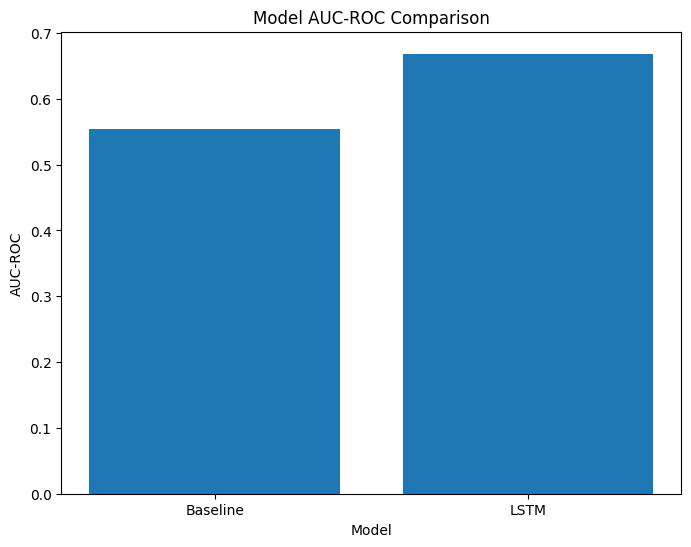

In [107]:
# Initialize the model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = lstm_model.fit(X_train_lstm, y_train.values, epochs=10, batch_size=72, validation_data=(X_test_lstm, y_test.values), verbose=2, shuffle=False)

# Predict class labels for the test set
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

# Compute AUC-ROC for the models
auc_roc_baseline = roc_auc_score(y_test.values, y_pred_baseline)
auc_roc_lstm = roc_auc_score(y_test.values, y_pred_lstm)

# Print the AUC-ROC
print("AUC-ROC for Baseline Model: ", auc_roc_baseline)
print("AUC-ROC for LSTM Model: ", auc_roc_lstm)

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Baseline', 'LSTM'], [auc_roc_baseline, auc_roc_lstm])
plt.xlabel('Model')
plt.ylabel('AUC-ROC')
plt.title('Model AUC-ROC Comparison')
plt.show()



**Cross Validation** 🏴‍☠️

**Feature Importance** ✈️

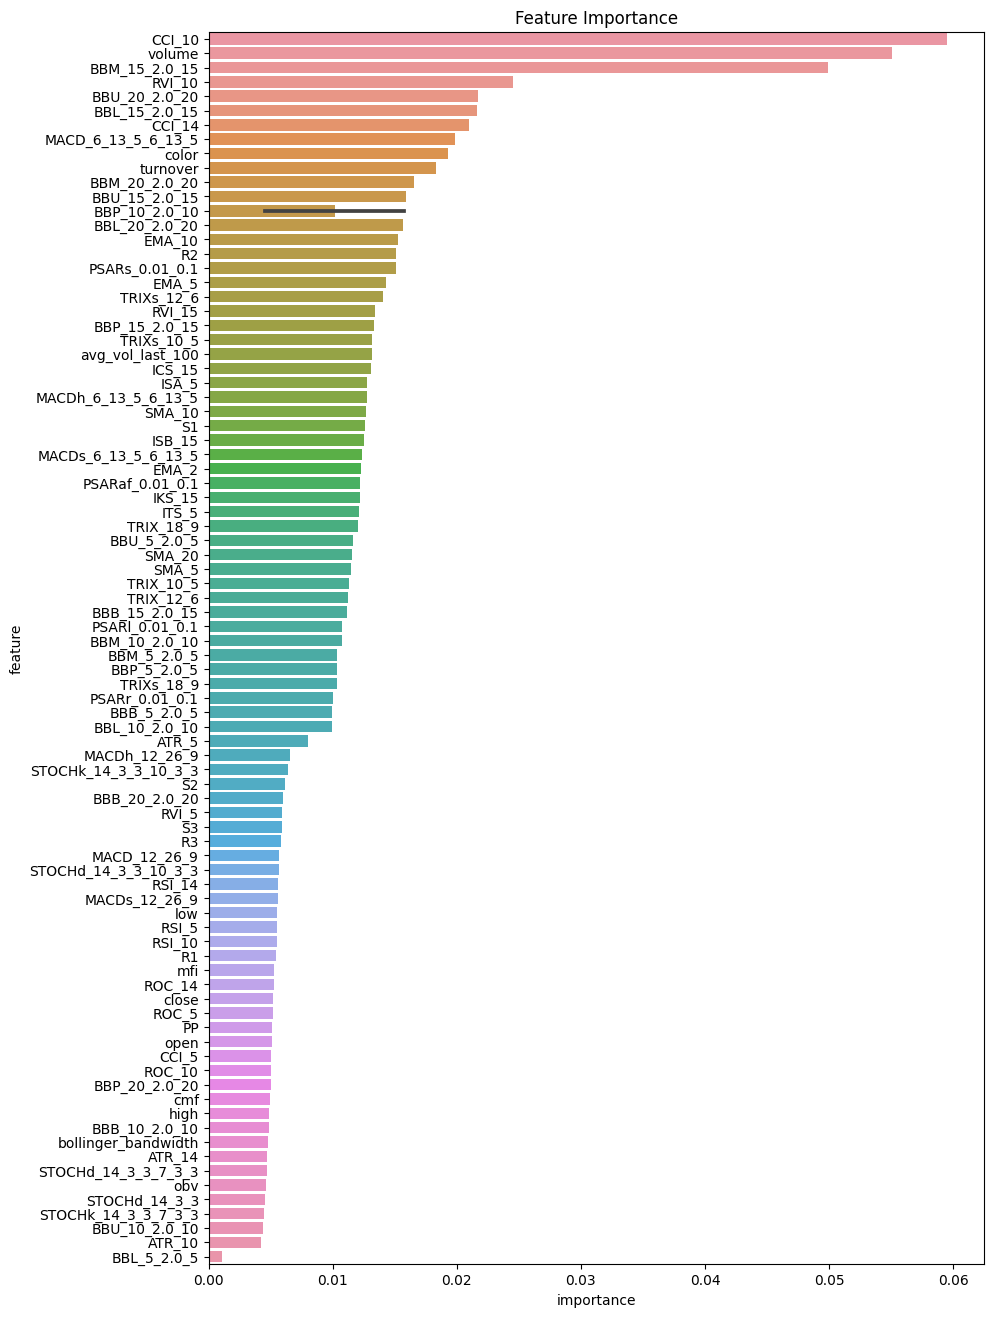

MACD_6_13_5_6_13_5
color
turnover
BBM_20_2.0_20
BBU_15_2.0_15
BBP_10_2.0_10
BBL_20_2.0_20
EMA_10
R2
PSARs_0.01_0.1
EMA_5
TRIXs_12_6
RVI_15
BBP_15_2.0_15
TRIXs_10_5
avg_vol_last_100
ICS_15
ISA_5
MACDh_6_13_5_6_13_5
SMA_10
S1
ISB_15
MACDs_6_13_5_6_13_5
EMA_2
PSARaf_0.01_0.1
IKS_15
ITS_5
TRIX_18_9
BBU_5_2.0_5
SMA_20
SMA_5
TRIX_10_5
TRIX_12_6
BBB_15_2.0_15
PSARl_0.01_0.1
BBM_10_2.0_10
BBM_5_2.0_5
BBP_5_2.0_5
TRIXs_18_9
PSARr_0.01_0.1
BBB_5_2.0_5
BBL_10_2.0_10
ATR_5
MACDh_12_26_9
STOCHk_14_3_3_10_3_3
S2
BBB_20_2.0_20
RVI_5
S3
R3
MACD_12_26_9
STOCHd_14_3_3_10_3_3
RSI_14
MACDs_12_26_9
low
RSI_5
RSI_10
R1
mfi
ROC_14
close
ROC_5
PP
open
CCI_5
ROC_10
BBP_20_2.0_20
cmf
high
BBB_10_2.0_10
bollinger_bandwidth
ATR_14
STOCHd_14_3_3_7_3_3
obv
BBP_10_2.0_10
STOCHd_14_3_3
STOCHk_14_3_3_7_3_3
BBU_10_2.0_10
ATR_10
BBL_5_2.0_5


In [108]:
# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train_base, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Map feature importances to the corresponding feature names
feature_importances = pd.DataFrame({'feature': feature_names, 
                                    'importance': importances}).sort_values('importance', 
                                                                            ascending=False)


# Visualize feature importances
plt.figure(figsize=(10, 16))
sns.barplot(data=feature_importances, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

# Filter features with importance below 0.01
low_importance_features = feature_importances[feature_importances['importance'] < 0.02]['feature']

# Print the low importance features
for feature in low_importance_features:
    print(feature)



In [109]:
# Initialize a list to hold AUC-ROC scores for each iteration
auc_roc_baseline_history = []
auc_roc_lstm_history = []

for feature in features_to_drop:
    # Drop one feature at a time
    features_df_temp = features_df.drop(feature, axis=1)

    # Split the data into train and test sets
    X_train_df, X_test_df = features_df_temp[:split_point], features_df_temp[split_point:]

    # Apply preprocessing to the train and test sets
    X_train_df, y_train = preprocess(X_train_df, y_train)
    X_test_df, y_test = preprocess(X_test_df, y_test)

    # Scale the data
    X_train_df = scaler.fit_transform(X_train_df)
    X_test_df = scaler.transform(X_test_df)

    # Reshape the data for LSTM
    X_train_lstm = X_train_df.reshape(X_train_df.shape[0], 1, X_train_df.shape[1])
    X_test_lstm = X_test_df.reshape(X_test_df.shape[0], 1, X_test_df.shape[1])

    # Reshape for the base model
    X_train_base = X_train_df
    X_test_base = X_test_df

    # Initialize the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    lstm_model.add(Dense(1, activation='sigmoid'))

    # Compile the LSTM model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the LSTM model
    history = lstm_model.fit(X_train_lstm, y_train.values, epochs=10, batch_size=72, 
                             validation_data=(X_test_lstm, y_test.values), verbose=2, shuffle=False)

    # Predict class labels for the test set
    y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

    # Compute AUC-ROC for the LSTM model
    auc_roc_lstm = roc_auc_score(y_test.values, y_pred_lstm)

    # Add the AUC-ROC score to the list
    auc_roc_lstm_history.append(auc_roc_lstm)

    # Initialize the model
    baseline_model = LogisticRegression(max_iter=5000)

    # Fit the model
    baseline_model.fit(X_train_base, y_train.values)

    # Predict the test set results
    y_pred_base = baseline_model.predict(X_test_base)

    # Compute AUC-ROC for the base model
    auc_roc_baseline = roc_auc_score(y_test.values, y_pred_base)

    # Add the AUC-ROC score to the list
    auc_roc_baseline_history.append(auc_roc_baseline)
    
# Function to divide the features_to_drop list into sublists of 20 features each
def divide_chunks(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Divide the features_to_drop list into sublists of 20 features each
chunk_size = 20
features_to_drop_chunks = list(divide_chunks(features_to_drop, chunk_size))

# Loop through the sublists and create a chart for each sublist
for chunk_index, features_to_drop_chunk in enumerate(features_to_drop_chunks):

    # Set the figure size
    plt.figure(figsize=(20, 10))

    # Plot the AUC-ROC for each iteration
    plt.plot(auc_roc_baseline_history[chunk_index * chunk_size:(chunk_index + 1) * chunk_size], 
             features_to_drop_chunk, marker='o', label='Baseline Model')
    plt.plot(auc_roc_lstm_history[chunk_index * chunk_size:(chunk_index + 1) * chunk_size], 
             features_to_drop_chunk, marker='o', label='LSTM Model')

    # Set the axes labels and title
    plt.ylabel('Dropped Feature')
    plt.xlabel('AUC-ROC')
    plt.title(f'AUC-ROC per Iteration of Dropped Feature (Chunk {chunk_index + 1})')

    # Set the x-axis ticks and labels
    plt.xticks(fontsize=8, rotation=45)

    # Set the y-axis ticks and labels
    plt.yticks(range(len(features_to_drop_chunk)), features_to_drop_chunk, fontsize=8)

    # Add colored rows for better readability
    for i in range(len(features_to_drop_chunk)):
        if i % 2 == 0:
            plt.fill_between(np.arange(-0.5, max(auc_roc_baseline_history + auc_roc_lstm_history) + 0.5, 0.01), 
                             i - 0.5, i + 0.5, color='gray', alpha=0.2)

    # Add the legend and display the chart
    plt.legend()
    plt.show()

Epoch 1/10
89/89 - 1s - loss: 0.6916 - accuracy: 0.5268 - val_loss: 0.6877 - val_accuracy: 0.5530 - 1s/epoch - 15ms/step
Epoch 2/10
89/89 - 0s - loss: 0.6877 - accuracy: 0.5502 - val_loss: 0.6884 - val_accuracy: 0.5493 - 183ms/epoch - 2ms/step
Epoch 3/10
89/89 - 0s - loss: 0.6834 - accuracy: 0.5700 - val_loss: 0.6939 - val_accuracy: 0.4935 - 193ms/epoch - 2ms/step
Epoch 4/10
89/89 - 0s - loss: 0.6757 - accuracy: 0.5878 - val_loss: 0.7053 - val_accuracy: 0.4755 - 188ms/epoch - 2ms/step
Epoch 5/10
89/89 - 0s - loss: 0.6619 - accuracy: 0.6235 - val_loss: 0.7125 - val_accuracy: 0.4935 - 189ms/epoch - 2ms/step
Epoch 6/10
89/89 - 0s - loss: 0.6420 - accuracy: 0.6532 - val_loss: 0.7133 - val_accuracy: 0.5189 - 187ms/epoch - 2ms/step
Epoch 7/10
89/89 - 0s - loss: 0.6189 - accuracy: 0.6794 - val_loss: 0.7061 - val_accuracy: 0.5505 - 179ms/epoch - 2ms/step
Epoch 8/10
89/89 - 0s - loss: 0.5959 - accuracy: 0.6985 - val_loss: 0.6872 - val_accuracy: 0.5976 - 182ms/epoch - 2ms/step
Epoch 9/10
89/89 -

ValueError: Data cardinality is ambiguous:
  x sizes: 6418
  y sizes: 6407
Make sure all arrays contain the same number of samples.